In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:

# 24/10/2024 BTC data
data = pd.read_csv('./data/bid_ask_data_BTCUSDT_20241024.csv')
print(data.shape)
data.head()


(835124, 42)


,Update ID,Timestamp,Bid Price 1,Bid Volume 1,Ask Price 1,Ask Volume 1,Bid Price 2,Bid Volume 2,Ask Price 2,Ask Volume 2,...,Ask Price 8,Ask Volume 8,Bid Price 9,Bid Volume 9,Ask Price 9,Ask Volume 9,Bid Price 10,Bid Volume 10,Ask Price 10,Ask Volume 10
0,53330284011,2024-10-24 00:00:00.042995+00:00,66668.65,0.89648,66668.66,6.05263,66668.50,0.00008,66668.7,0.00045,...,66670.78,0.00008,66666.40,0.00016,66671.5,0.1198,66666.01,0.10752,66672.0,0.0872
1,53330284035,2024-10-24 00:00:00.142715+00:00,66668.65,0.89527,66668.66,6.05263,66668.64,0.00009,66668.7,0.00045,...,66670.78,0.00008,66667.46,0.00008,66671.5,0.1198,66666.67,0.00471,66672.0,0.0872
2,53330284055,2024-10-24 00:00:00.243144+00:00,66668.65,0.89527,66668.66,6.42482,66668.64,0.00009,66668.7,0.00045,...,66670.78,0.00008,66667.46,0.00008,66671.5,0.1198,66666.67,0.00471,66672.0,0.0872
3,53330284065,2024-10-24 00:00:00.342400+00:00,66668.65,0.89509,66668.66,6.42482,66668.64,0.00009,66668.7,0.00045,...,66670.78,0.00008,66667.46,0.00008,66671.5,0.1198,66666.67,0.00471,66672.0,0.0872
4,53330284080,2024-10-24 00:00:00.442810+00:00,66668.65,0.88767,66668.66,7.17551,66668.64,0.00009,66668.7,0.00045,...,66670.78,0.00008,66667.46,0.00008,66671.5,0.1198,66666.67,0.00471,66672.0,0.0872


In [3]:
# Calculate Midprice
data['Midprice'] = (data['Bid Price 1'] + data['Ask Price 1']) / 2

## Label Encoding

In this project, our goal is to predict the evolution of the **midprice**, classifying it into three categories: **Up**, **Down**, or **Stable**. To achieve this, we must first encode fluctuations in the midprice.

### Horizon k trend prediction

The mid price is calculated as the average of the best ask price and the best bid price from the order book.

$$m(t) = \frac{P_{\text{ask}}(t) + P_{\text{bid}}(t)}{2}$$

The midprice fluctuation between $t$ and $t+k$ is encoded as follow : 

**Downward (-1):** The future midprice is lower than the current midprice by a threshold $\theta$:

$$
m(t+k) < m(t) \cdot (1 + \theta)
$$

**Stable (0):** The future midprice lies within the threshold range:

$$
m(t+k) \in \left[m(t) \cdot (1 - \theta), m(t) \cdot (1 + \theta)\right]
$$


**Upward (+1):** The future midprice exceeds the current midprice by a threshold $\theta$:

$$
m(t+k) > m(t) \cdot (1 + \theta)
$$





- In our model, time $t$ is measured in "tick time," which corresponds to consecutive updates of the limit order book (LOB), making it a natural choice for financial instruments.

- A higher value of $\theta$ reduces the noise.

- the value of $m(t+k)$ might be highly influenced by noise.

### Horizon k smoothed trend Prediction


To reduce noise, we employ a **smoothed labeling approach**, which defines trends by comparing the current midprice with the average midprices over a future time horizon. The process is outlined below:

The smoothed midprice average over a horizon $k$ is defined as:

$$
a^+(k, t) = \frac{1}{k} \sum_{i=1}^{k} m(t + i)
$$

$k$ represents the number of future time steps considered.

Using the current midprice $m(t)$ and the smoothed future midprice $a^+(k, t)$, the trend at time $t$ is classified into one of three categories:

**Upward (U):** The future smoothed midprice exceeds the current midprice by a threshold $\theta$:

$$
a^+(k, t) > m(t) \cdot (1 + \theta)
$$

**Downward (D):** The future smoothed midprice is lower than the current midprice by a threshold $\theta$:

$$
a^+(k, t) < m(t) \cdot (1 - \theta)
$$

**Stable (S):** The future smoothed midprice lies within the threshold range:

$$
a^+(k, t) \in \left[m(t) \cdot (1 - \theta), m(t) \cdot (1 + \theta)\right]
$$

This approach reduces noise caused by small fluctuations in the midprice by considering smoothed averages over a desired horizon $k$. It also avoids overfitting by treating minor variations as part of the stable class.


- In the literature, the $\theta$ is choose to have a balanced class.
- The values of horizons studied are $k \in [10, 20, 50, 100]$

### Another way of encoding




$$
m^-(t) = \frac{1}{k} \sum_{i=0}^{k-1} m(t-i),
$$

$$
m^+(t) = \frac{1}{k} \sum_{i=1}^k m(t+i).
$$


$$
l_t = \frac{m^+(t) - m^-(t)}{m^-(t)},
$$


Here, $k$ is the prediction horizon, and $m(t)$ is the mid-price at time $t$. We compare $l_t$ with a threshold ($\theta$) to decide on the label:

- If $l_t > \theta$, the label is **up**.
- If $l_t < -\theta$, the label is **down**.
- Otherwise, the label is **stable**.


In [14]:

# This function return the encoded label column with parameters (horizon, theta)
def get_midprice_variation_column(data, horizon, theta):

    future_means = data['Midprice'].shift(-1).rolling(window=horizon, min_periods=1).mean()
    variation = (future_means - data['Midprice']) / data['Midprice'] * 100
    data['label'] = pd.cut(variation, bins=[-np.inf, -theta, theta, np.inf], labels=['D', 'S', 'U'])

    return data['label']

def get_class_dist(column):
    return column.value_counts(normalize=True).to_dict()

# Function to plot the distribution of encoded classes
def plot_class_distribution(column):

    class_counts = column.value_counts(normalize = True)

    plt.figure(figsize=(6, 4))
    class_counts.plot(kind='bar')
    plt.title(f"Class Distribution")
    plt.xlabel('Classes')
    plt.ylabel('Frequency (%)')
    plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
    plt.grid(alpha=0.3)
    plt.show()


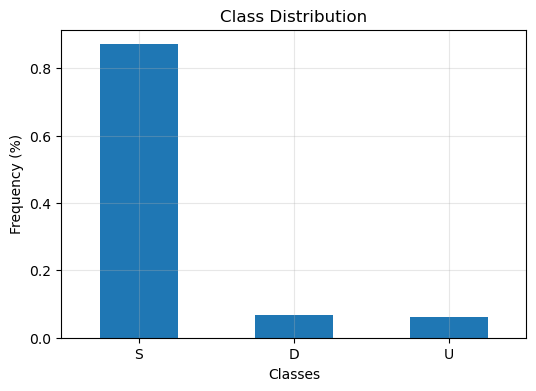

In [15]:
encoded_labels = get_midprice_variation_column(data, 10, 0.001)

plot_class_distribution(encoded_labels)

As in the literature we can choose a value of $\theta$ that gives a balanced dataset, this can help to have a better algorithm, that learn every class.

### Parameters selection

We will use the entropy fonction, to determine if a distribution is balanced or not.

The normalized entropy for a distribution over 3 classes is calculated as:

$$
H = -\frac{1}{\log(3)} \sum_{i=1}^{3} p_i \log(p_i)
$$

Where:
- $p_i$ is proportion of the $i^{th}$ class.
- $log(3)$ is the maximum possible entropy for 3 classes, used for normalization.
- $H$ is the normalized entropy, which lies between 0 (totaly unbalanced) and 1 (perfectly balanced).

In [19]:

def get_distribution_entropy(labels_column):

    class_counts = labels_column.value_counts(normalize = True)

    entropy = sum([- p * np.log(p) for p in class_counts if p > 0]) / np.log(3)

    return entropy


We can plot the distribution of the values in variation for different values of variation, to see which values of theta might be interesting.

In [53]:

def find_best_theta(data, k):
    
    theta_range = np.linspace(1e-5, 1e-2, 100)
    best_theta = None
    best_dist = None
    max_entropy = float('-inf')

    print(f'Research of the best theta for k = {k}...')

    for theta in theta_range:
        labels = get_midprice_variation_column(data.copy(), k, theta)
        entropy = get_distribution_entropy(labels)

        if entropy > max_entropy:
            max_entropy = entropy
            best_theta = theta
            best_dist = get_class_dist(labels)

    print(f'The best theta is : {best_theta}')
    print(f'With an entropy of : {max_entropy}')
    print(f'With a distribution : ')
    print(best_dist)
    print('')

    return best_theta, best_dist

#best_theta, best_dist = find_best_theta(data, k = 50)
    

In [55]:

def parameters_summary(data, k_values):
    results = []
    for k in k_values:
        best_theta, best_dist = find_best_theta(data, k)
        
        s_dist = best_dist.get('S', 0) * 100
        d_dist = best_dist.get('D', 0) * 100
        u_dist = best_dist.get('U', 0) * 100
        
        results.append({
            "k": k,
            "Theta (1e-4)": best_theta*10000,
            "Stable (%)": round(s_dist, 1),
            "Downward (%)": round(d_dist, 1),
            "Upward (%)": round(u_dist, 1)
        })
    
    # Create a DataFrame from the results
    df = pd.DataFrame(results)
    return df

k_values = [10, 25, 50, 100]  # Replace with your desired k values
df_results = parameters_summary(data, k_values)
df_results


Research of the best theta for k = 10...
The best theta is : 1e-05
With an entropy of : 0.586871196181358
With a distribution : 
{'S': 0.7972085582500323, 'D': 0.10402766535269015, 'U': 0.09876377639727753}

Research of the best theta for k = 25...
The best theta is : 1e-05
With an entropy of : 0.8451418613576837
With a distribution : 
{'S': 0.618972751351895, 'D': 0.19652171414065456, 'U': 0.18450553450745039}

Research of the best theta for k = 50...
The best theta is : 1e-05
With an entropy of : 0.9757256092176648
With a distribution : 
{'S': 0.44384785971903573, 'D': 0.288339216691174, 'U': 0.26781292358979025}

Research of the best theta for k = 100...
The best theta is : 0.0006154545454545456
With an entropy of : 0.9995508828888509
With a distribution : 
{'D': 0.3445440437587712, 'S': 0.3360662608187527, 'U': 0.3193896954224762}



,k,Theta (1e-4),Stable (%),Downward (%),Upward (%)
0,10,0.100000,79.7,10.4,9.9
1,25,0.100000,61.9,19.7,18.5
2,50,0.100000,44.4,28.8,26.8
3,100,6.154545,33.6,34.5,31.9
